## Encode Variables

In [1]:
import pandas as pd

df = pd.read_csv("../../datasets/orgxplor_interest_responses.csv")

In [2]:
df.keys()

Index(['Timestamp', 'What year are you?',
       'What are your extracurricular interests? (Choose all that apply)',
       'Preferred Activities (Choose all that apply)', 'What is your major?',
       'Would you be interested in joining ethnic-oriented organizations?\r\n(Examples: Cultural clubs, heritage-based student groups)',
       'Optional Question (If Yes):\r\nIf comfortable, please share your ethnic identity. This will help us match you with relevant groups and events.\r\n\r\nOptions (Select all that apply or specify your own)  ',
       'Would you be interested in joining faith or religion-oriented organizations?\r\n(Examples: Student groups or clubs focused on specific religious practices, interfaith events, or spiritual activities)',
       'Optional Question (If Yes):\r\nIf comfortable, please share your religious or spiritual identity. This will help us match you with relevant groups and events.\r\n\r\n(Select all that apply or specify your own)  ',
       'How frequently

In [3]:
from collections import Counter
from typing import List
import numpy as np

key_time_stamp = 'Timestamp'
key_year_study = 'What year are you?'
key_extracurricular = 'What are your extracurricular interests? (Choose all that apply)'
key_activities = 'Preferred Activities (Choose all that apply)'
key_major = 'What is your major?'
key_ethnic_org = 'Would you be interested in joining ethnic-oriented organizations?\r\n(Examples: Cultural clubs, heritage-based student groups)'
key_ethnic_id = 'Optional Question (If Yes):\r\nIf comfortable, please share your ethnic identity. This will help us match you with relevant groups and events.\r\n\r\nOptions (Select all that apply or specify your own)  '
key_faith_org = 'Would you be interested in joining faith or religion-oriented organizations?\r\n(Examples: Student groups or clubs focused on specific religious practices, interfaith events, or spiritual activities)'
key_faith_id = 'Optional Question (If Yes):\r\nIf comfortable, please share your religious or spiritual identity. This will help us match you with relevant groups and events.\r\n\r\n(Select all that apply or specify your own)  '
key_attend_freq = 'How frequently do you prefer to attend campus events?  '
key_time_of_day = 'What time of day do you generally prefer for events? Select all that apply. '
key_achieve = 'What do you hope to achieve by attending events?  '
key_academic = 'Do you seek events for academic support?'
key_reminders = 'How would you prefer to receive event reminders?  '
key_diversity_inclusion = 'Would you like to see events that promote diversity and inclusion?  '
key_prompt_feedback = 'Would you like to be prompted for feedback after each event or periodically? '

class Preprocessing:
    # Robust detection of multiple classes.
    def _detect_multiclass(text: str, classes: List[str], all_above_cls: str|None = None):
        text = text.lower()

        if all_above_cls and all_above_cls in text:
            return classes
        
        detected: List[str] = []
        for cls in classes:
            if cls.lower() in text:
                detected.append(cls)

        return detected

    def get_extracurricular(text: str):
        interests = ["Music", "Fashion",
                    "Arts & Media", "Recreational Sports",
                    "Video Games", "Social Events",
                    "Literature"]

        return Preprocessing._detect_multiclass(text, interests, all_above_cls="All of the Above")

    def get_ethnic(text: str):
        identities = [
            "African/African American/Black",
            "Asian/Pacific Islander",
            "Hispanic/Latino",
            "Indigenous/Native American",
            "Middle Eastern/North African",
            "White/European Descent",
            "Multiracial",
        ]
        
        return Preprocessing._detect_multiclass(text, identities)

    def get_faith(text: str):
        faiths = ["Buddhism", "Christianity",
                "Hinduism", "Islam",
                "Judaism", "Sikhism",
                "Spiritual but not religious"]
        
        return Preprocessing._detect_multiclass(text, faiths)

    def get_activities(text: str):
        activities = ["Competitions", "Information Sessions", 
                    "Volunteering", "Networking", 
                    "Workshops", "Social Gatherings"]
        
        return Preprocessing._detect_multiclass(text, activities)
    
    def get_times(text: str):
        text = text.lower()

        times = [f"{hour}:{minute:02} {meridiem}"
            for meridiem in ["AM", "PM"]
            for hour in [12] + list(range(1,12))
            for minute in range(0, 60, 15)
        ]
        user_times = []
        if "morning" in text:
            user_times += [f"{hour}:{minute:02} {meridiem}"
                for meridiem in ["AM"]
                for hour in range(8, 12)
                for minute in range(0, 60, 15)
            ]
        if "afternoon" in text:
            user_times += [f"{hour}:{minute:02} {meridiem}"
                for meridiem in ["PM"]
                for hour in [12] + list(range(1,4))
                for minute in range(0, 60, 15)
            ]
        if "evening" in text:
            user_times += [f"{hour}:{minute:02} {meridiem}"
                for meridiem in ["PM"]
                for hour in range(4, 8)
                for minute in range(0, 60, 15)
            ]
        if "night" in text:
            user_times += [f"{hour}:{minute:02} {meridiem}"
                for meridiem in ["PM"]
                for hour in range(8, 12)
                for minute in range(0, 60, 15)
            ]
        return user_times
    
    def get_achieve(text: str):
        achievements = [
            "Meeting new people",
            "Building professional connections",
            "Gaining academic knowledge",
            "Exploring new hobbies and interests"
        ]
        return Preprocessing._detect_multiclass(text, achievements)
    
    def get_remind_preference(text: str):
        preference = [
            "App notifications",
            "Email",
            "SMS/Text",
            "None",
        ]
        return Preprocessing._detect_multiclass(text, preference)

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_extracurricular = MultiLabelBinarizer()
encoded = mlb_extracurricular.fit_transform([Preprocessing.get_extracurricular(text) for text in df[key_extracurricular]])

df = df.join(pd.DataFrame(encoded, columns=["Extracurricular: " + e for e in mlb_extracurricular.classes_]))

In [5]:
mlb_ethnic = MultiLabelBinarizer()
encoded = mlb_ethnic.fit_transform([Preprocessing.get_ethnic(str(text)) for text in df[key_ethnic_id]])

df = df.join(pd.DataFrame(encoded, columns=["Ethnic Identity: " + e for e in mlb_ethnic.classes_]))

In [6]:
mlb_faith = MultiLabelBinarizer()
encoded = mlb_faith.fit_transform([Preprocessing.get_faith(str(text)) for text in df[key_faith_id]])

df = df.join(pd.DataFrame(encoded, columns=["Faith: " + f for f in mlb_faith.classes_]))

In [7]:
mlb_activities = MultiLabelBinarizer()
encoded = mlb_activities.fit_transform([Preprocessing.get_activities(text) for text in df[key_activities]])

df = df.join(pd.DataFrame(encoded, columns=["Activity: " + a for a in mlb_activities.classes_]))

In [8]:
mlb_times = MultiLabelBinarizer()
encoded = mlb_times.fit_transform([Preprocessing.get_times(str(text)) for text in df[key_time_of_day]])

df = df.join(pd.DataFrame(encoded, columns=["Time Available: " + t for t in mlb_times.classes_]))

In [9]:
mlb_achieve = MultiLabelBinarizer()
encoded = mlb_achieve.fit_transform([Preprocessing.get_achieve(str(text)) for text in df[key_achieve]])

df = df.join(pd.DataFrame(encoded, columns=["Hope to Achieve: " + a for a in mlb_achieve.classes_]))

In [10]:
mlb_remind = MultiLabelBinarizer()
encoded = mlb_remind.fit_transform([Preprocessing.get_remind_preference(str(text)) for text in df[key_reminders]])

df = df.join(pd.DataFrame(encoded, columns=["Remind Preference: " + p for p in mlb_remind.classes_]))

In [11]:
df[key_major].fillna("Other")
df[key_major] = df[key_major].fillna("Other")

In [12]:
from sklearn.preprocessing import OneHotEncoder

ohe_study = OneHotEncoder()
encoded: np.ndarray = ohe_study.fit_transform(df[[key_major]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Major: " + m for m in ohe_study.categories_[0]]))

In [13]:
ohe_ethnic = OneHotEncoder()
encoded: np.ndarray = ohe_ethnic.fit_transform(df[[key_ethnic_org]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Join Ethnic Group: " + ans for ans in ohe_ethnic.categories_[0]]))

In [14]:
ohe_faith = OneHotEncoder()
encoded: np.ndarray = ohe_faith.fit_transform(df[[key_faith_org]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Join Faith Group: " + ans for ans in ohe_faith.categories_[0]]))

In [15]:
ohe_attend_freq = OneHotEncoder()
encoded: np.ndarray = ohe_attend_freq.fit_transform(df[[key_attend_freq]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Attendance Frequency: " + ans for ans in ohe_attend_freq.categories_[0]]))

In [16]:
ohe_academic = OneHotEncoder()
encoded: np.ndarray = ohe_academic.fit_transform(df[[key_academic]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Events for Academic Support: " + ans for ans in ohe_academic.categories_[0]]))

In [17]:
diversity = OneHotEncoder()
encoded: np.ndarray = diversity.fit_transform(df[[key_diversity_inclusion]]).toarray()
encoded = encoded.astype(np.int32)
df = df.join(pd.DataFrame(encoded, columns=["Events for Diversity and Inclusion: " + ans for ans in diversity.categories_[0]]))

In [18]:
df.to_csv("../../datasets/orgxplor_interest_responses_processed.csv")

## Visualizations

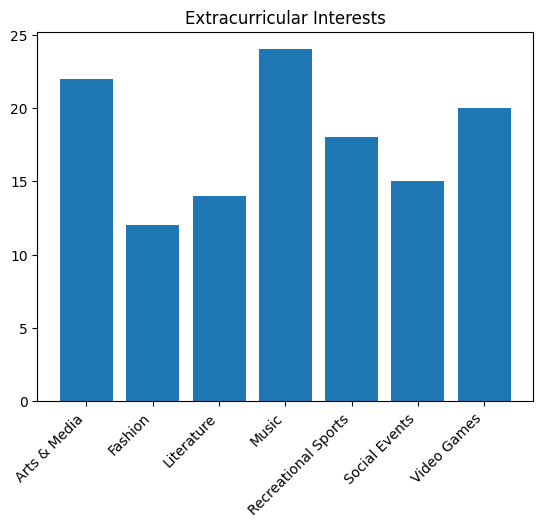

In [50]:
import matplotlib.pyplot as plt

columns=["Extracurricular: " + e for e in mlb_extracurricular.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Extracurricular Interests")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

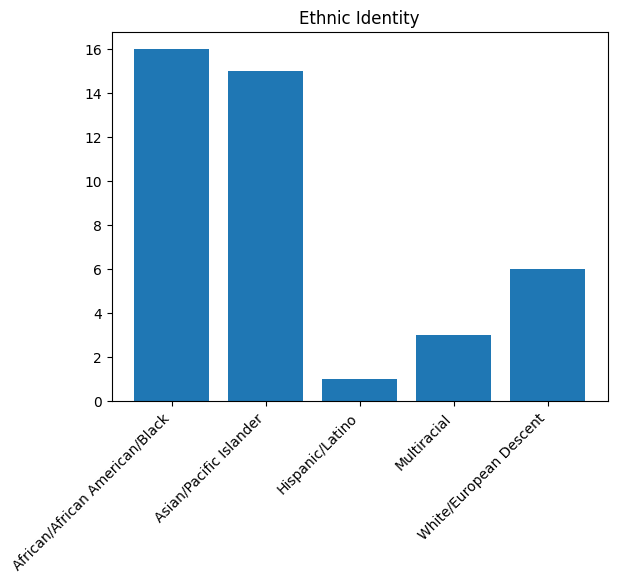

In [51]:
import matplotlib.pyplot as plt

columns=["Ethnic Identity: " + e for e in mlb_ethnic.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Ethnic Identity")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

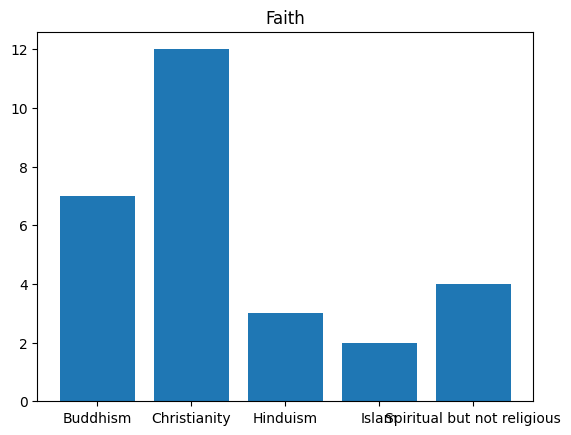

In [52]:
import matplotlib.pyplot as plt

columns=["Faith: " + f for f in mlb_faith.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Faith")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()

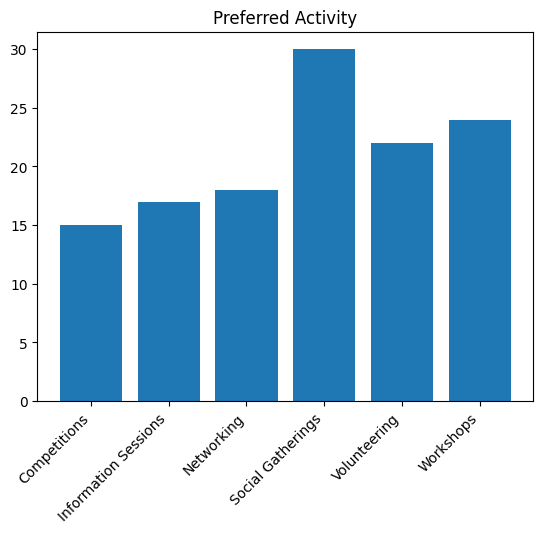

In [53]:
import matplotlib.pyplot as plt

columns=["Activity: " + a for a in mlb_activities.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Preferred Activity")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

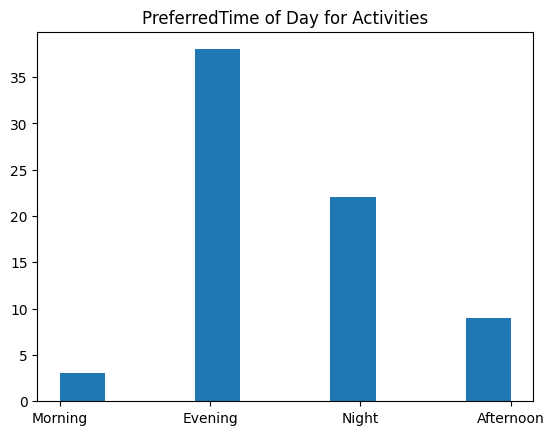

In [55]:
import matplotlib.pyplot as plt

def get_general_tod(text: str) -> List[str]:
    result = []

    if "morning" in text.lower():
        result.append("Morning")
    if "afternoon" in text.lower():
        result.append("Afternoon")
    if "evening" in text.lower():
        result.append("Evening")
    if "night" in text.lower():
        result.append("Night")
    
    return result

columns=[]

plt.title("PreferredTime of Day for Activities")
for item in df[key_time_of_day]:
    columns += get_general_tod(item)

plt.hist(columns)
plt.show()

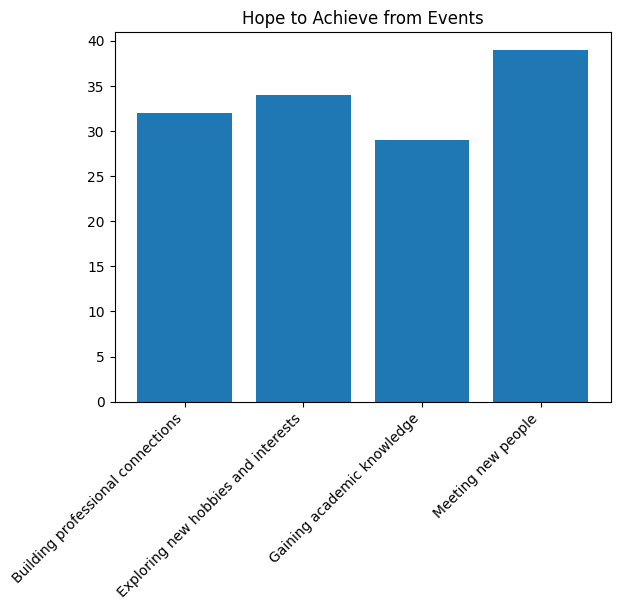

In [56]:
import matplotlib.pyplot as plt

columns=["Hope to Achieve: " + a for a in mlb_achieve.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Hope to Achieve from Events")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

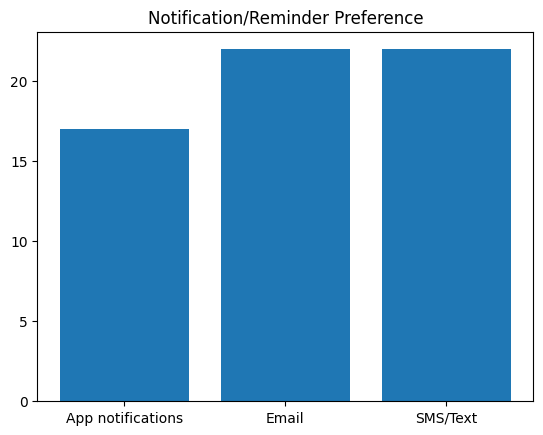

In [57]:
import matplotlib.pyplot as plt

columns=["Remind Preference: " + p for p in mlb_remind.classes_]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Notification/Reminder Preference")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()

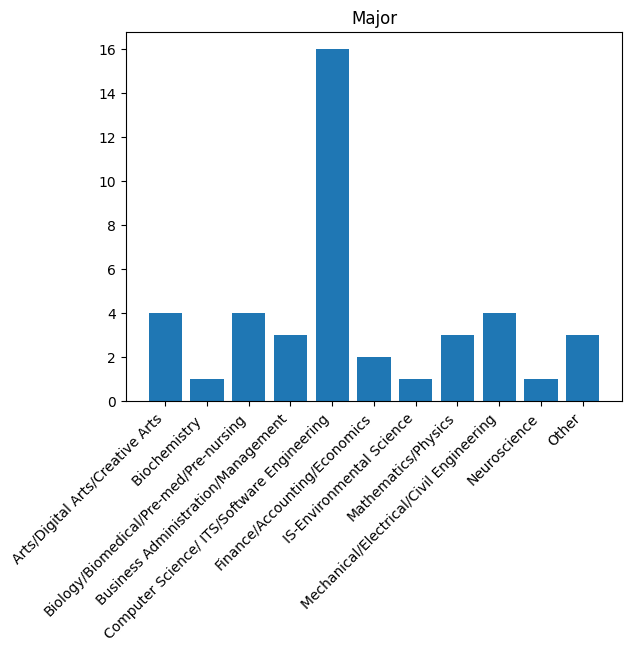

In [58]:
import matplotlib.pyplot as plt

columns=["Major: " + m for m in ohe_study.categories_[0]]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Major")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

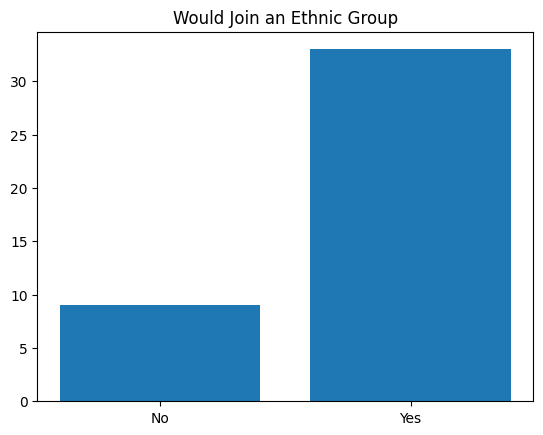

In [59]:
import matplotlib.pyplot as plt

columns=["Join Ethnic Group: " + ans for ans in ohe_ethnic.categories_[0]]

plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.title("Would Join an Ethnic Group")
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()

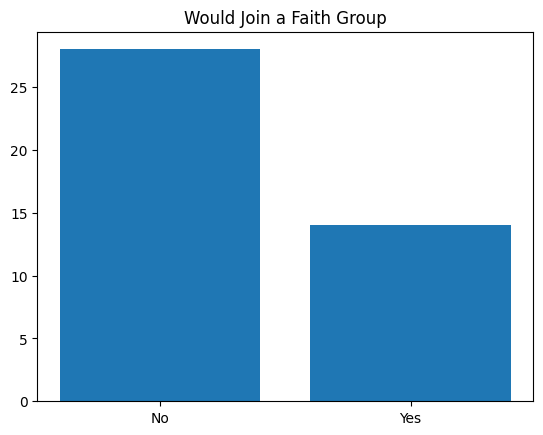

In [60]:
import matplotlib.pyplot as plt

columns=["Join Faith Group: " + ans for ans in ohe_faith.categories_[0]]

plt.title("Would Join a Faith Group")
plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()

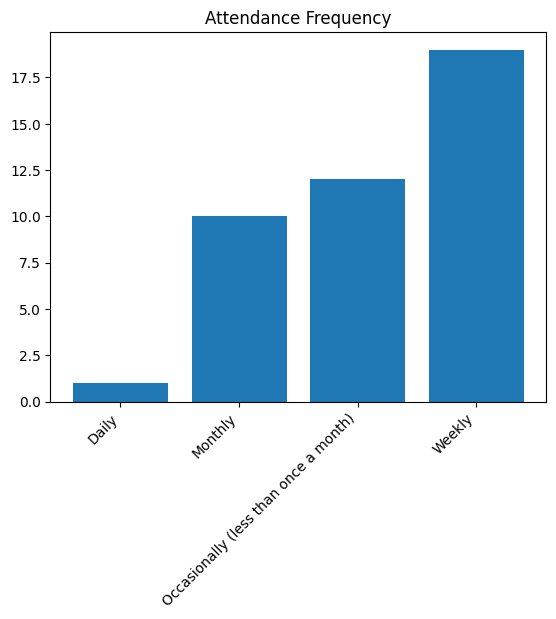

In [61]:
import matplotlib.pyplot as plt

columns=["Attendance Frequency: " + ans for ans in ohe_attend_freq.categories_[0]]

plt.title("Attendance Frequency")
plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns], rotation=45, ha="right")
plt.show()

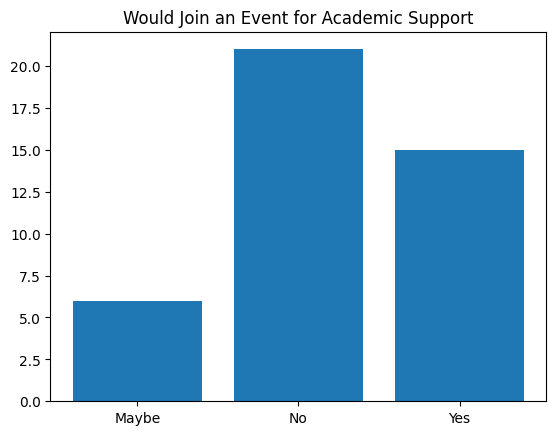

In [62]:
import matplotlib.pyplot as plt

columns=["Events for Academic Support: " + ans for ans in ohe_academic.categories_[0]]

plt.title("Would Join an Event for Academic Support")
plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()

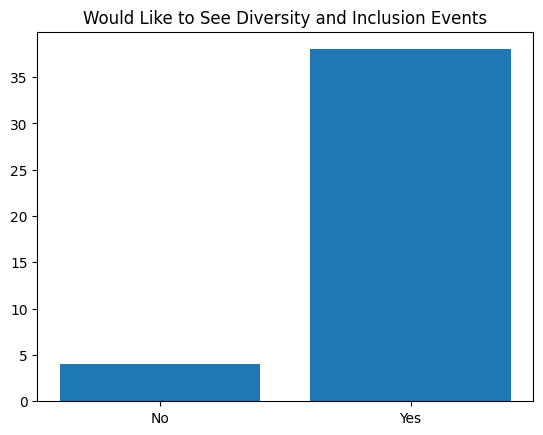

In [63]:
import matplotlib.pyplot as plt

columns=["Events for Diversity and Inclusion: " + ans for ans in diversity.categories_[0]]

plt.title("Would Like to See Diversity and Inclusion Events")
plt.bar(range(len(columns)), [df[k].sum() for k in columns])
plt.xticks(ticks=range(len(columns)), labels=[c.split(": ")[1] for c in columns])
plt.show()